# 二. k近邻算法

k近邻法(`k-nearest neighbor, k-NN`)是一种基本分类和回归方法(`Cover & Hart, 1968`)。k近邻法的输入为实例的特征向量，对应于特征空间的点，输出为实例的类别，可以取多类。分类时，对新的实例，根据其k个最近邻的训练实例的类别，根据其k个最近邻的训练实例的类别，通过多数表决等方式进行预测。

k近邻法不具显式的学习过程，k值的选择、距离度量以及分类决策规则是k近邻法的三要素。难点在于如何高效地定位到输入实例的k个最近邻居。

![](../pictures/3.1.svg)

> 绿点应属于哪一类？

## 1. `k`近邻算法

**算法3.1（`k`近邻法）**
- 输入：训练数据集
$$
T=\{(x_1, y_1), (x_2, y_2), ..., (x_N, y_N)\}
$$
其中，$x_i\in\mathbf{x}\subset \mathbf{R^n}$为实例的特征向量，$y_i\in \mathbf{y}=\{c_1,c_2,...,c_K\}$为实例的类别，$i=1,2,...,N$；实例特征向量$x$；
- 输出：实例$x$的所属类$y$
- 算法过程
    - 根据给定的距离度量，在训练集$T$中找出与$x$最近邻的$k$个点，涵盖这$k$个点的$x$的近邻记作$N_K(x)$
    - 在$N_k(x)$中根据分类决策规则决定$x$类别$y$
    $$
    y=\mathrm{arg} \max_{c_j} \sum_{x_i\in N_k(x)} I(y_i=c_i),i=1,2,...,N;j=1,2,...,K
    $$
    上式中，I为指示函数，即当$y_i=c_j$时$I$为1，否则$I$为0.

## 2. 距离度量

- $L_p$距离

设特征空间$\mathbf{X}$是n维实数向量空间$\mathbf{R^n}$，$x_i, x_j\in \mathbf{x}, x_i = (x^{(1)}_i,x^{(2)}_i,...,x^{(n)}_i)^T,x_j=(x_j^{(1)}, x_j^{(2)},... ,x_j^{(n)})^T,x_i,x_j$的$L_p$距离定义为
$$
L_p(x_i,x_j)=\left(\sum_{l=1}^n|x_i^{(l)}-x_j^{(l)}|^p\right)^{\frac{1}{p}}
$$
这里$p\ge 1$。

当$p=2$时，称为欧式距离(`Euclidean distance`)，即
$$
L_2(x_i,x_j)=\left(\sum_{l=1}^n|x_i^{(l)}-x_j^{(l)}|^2\right)^{\frac{1}{2}}
$$

当$p=1$时，称为曼哈顿距离(`Manhattan distance`)，即
$$
L_1(x_i,x_j)=\left(\sum_{l=1}^n|x_i^{(l)}-x_j^{(l)}|\right)
$$

当$p=\infty$时，它是各个坐标距离的最大值，即
$$
L_{\infty}(x_i,x_j)=\max_l|x_i^{(l)}-x_j^{(l)}|
$$

In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import time

In [2]:
def distance(xi, xj, p=2):
    if np.isinf(p):
        return np.max(np.abs(xi - xj))
    
    return np.sum((np.abs(xi - xj))**p)**(1/p)

In [3]:
x1 = np.array([1, 2, 3])
x2 = np.array([3, 2, 1])

In [4]:
distance(x1, x2, p=1)

4.0

In [5]:
distance(x1, x2, p=np.inf)

2

- 蛮力搜索

逐一计算点和所有其它点的距离，然后选出最近距离点

In [6]:
def brute_force_knn(x, X, k):
    dist_list = []
    for i in range(len(X)):
        dist_list.append([distance(X[i], x), i])
        
    top_k = sorted(dist_list)[:k]
    return top_k

## 3. `kd`树
解决如何存储和检索数据，以使搜索效率最优化

### 3.1. 构造`kd`树

注意，`kd`树是存储`k`维空间数据的树结构，这里的`k`与`k近邻`中的的`k`意义不同。

通常，依次选择坐标轴对空间划分，选择训练实例点在选定坐标轴上的中位数为切分点，这样得到的`kd`树是平衡的。

`kd`树是一种对`k`维空间中的实例点进行存储以便对其进行快速检索的树型数据结构。

`kd`树是二叉树，表示对`k`维空间的一个划分。

构造`kd`树相当于不断地用垂直于坐标轴的超平面将`k`维空间切分，构成一系列的`k`维超矩形区域。

`kd`树的每一个结点对应于一个`k`维矩形区域。

**算法3.2（构造平衡kd数）**
- 输入：k维空间数据集$T=\{(x_1, y_1), (x_2, y_2), ..., (x_N, y_N)\}$，其中$x_i = (x^{(1)}_i,x^{(2)}_i,...,x^{(n)}_i)^T,i=1,2,...,N$
- 输出：kd平衡树
- 算法过程：
    - 开始：构造根结点，根结点对应于包含T的k维空间的超矩形区域。选择以$x^{(1)}$为坐标轴，以T中所有实例的$x^{(1)}$坐标的*中位数*为切分点，将根结点对应的超矩形区域切分成两个子区域。切分由通过切分点并与坐标轴$x^{(1)}$垂直的超平面实现。由根结点生成深度为1的左右子结点：左子区域对应$x^{(1)}$小于切分点的子区域，右子区域对应$x^{(1)}$大于切分点的子区域。将落在切分超平面上的实例点保存在根结点。
    - 重复：对深度为j的结点，选择$x^{(l)}$为切分的坐标轴，$l=(j\ \text{mod}\ k) + 1$，以该节点的区域所有实例的$x^{(1)}$坐标的中位数为切分点，将该结点对应的超矩形区域切分为两个子区域。切分由通过切分点并与坐标轴$x^{(j)}$垂直的超平面实现。由根结点生成深度为$j+1$的左右子结点：左子区域对应$x^{(l)}$小于切分点的子区域，右子区域对应$x^{(l)}$大于切分点的子区域。将落在切分超平面上的实例点保存在该结点。
    - 直到两个区域没有实例存在时停止。从而形成kd树的区域划分。
 

问题：
- 如果使用中位数作为切分点，非叶结点上可能没有数据，如何处理？
- 多个数据保留在非叶结点上，如何处理？
- 倒数第二层只有2个结点，继续分时缺少右子结点，如何继续往下分？

#### 3.1.1. 基于递归生成kd树

结点如何生长？
- 如果结点对应数据个数不大于1，则停止增长
- 如果结点对应数据个数大于1，则继续生成两个后代结点
    - 按照指定维度的数据切分为两部分，下分给两个后代节点

可以利用递归思想生成kd树。

In [7]:
def generate_node_id(start=0, step=1):
    '''
    用于生成结点编号
    '''
    node_id = start
    while True:
        yield node_id
        node_id += step

In [16]:
def gen_kdTree_recur(X, y, dim, node_id=0, kd_tree=nx.DiGraph()):
    '''
    X: numpy.ndarray
    y: numpy.ndarray
    k: 实例的维度
    dim: 当前结点所处的维度
    node_id: 当前结点的编号
    '''
    k = X.shape[1]
    if node_id == 0:  # 根结点
        kd_tree.add_node(node_id)
        
    if y.size >= 2:  # 如果有两个以上的结点，继续往下分
        x_dim = X[:, dim]  # 取当前维度数据
        next_dim = (dim + 1) % k  # 获取下一代结点数据的切分维度
        s_indices = np.argsort(x_dim)  # 获取按x_dim由小到大排序的各特征索引
        m = len(s_indices) // 2  # 中间或中间靠左的索引
        l_indices = s_indices[:m]  # 左子区域索引
        m_idx = s_indices[m]  # 留在结点上的数据索引
        r_indices = s_indices[m + 1:]  # 右子区域索引
        l_X, l_y = X[l_indices], y[l_indices]
        r_X, r_y = X[r_indices], y[r_indices]
        l_node_id = next(nodeId_gen)  # 获取下一个左结点编号
        r_node_id = next(nodeId_gen)  # 获取下一个右结点编号
        # 添加当前结点到子节点的连边
        kd_tree.add_edges_from([(node_id, l_node_id), (node_id, r_node_id)])  
        kd_tree.nodes[node_id]["l_succ"] = l_node_id
        kd_tree.nodes[node_id]["r_succ"] = r_node_id
        kd_tree.nodes[node_id]["dim"] = dim  # 结点的切分维度
        kd_tree.nodes[node_id]["point"] = (X[m_idx], y[m_idx])  # 当前结点上的数据
        kd_tree.nodes[node_id]["node_type"] = 'root' if node_id == 0 else 'non-leaf'
        
        kd_tree = gen_kdTree_recur(l_X, l_y, next_dim, l_node_id, kd_tree)  # 递归左子结点
        kd_tree = gen_kdTree_recur(r_X, r_y, next_dim, r_node_id, kd_tree)  # 递归左子结点
    else:  # 如果少于2个结点，则将当前结点设为叶结点
        kd_tree.nodes[node_id]['node_type'] = 'leaf'
        if y.size == 1:
            kd_tree.nodes[node_id]["dim"] = dim  # 结点的切分维度
            kd_tree.nodes[node_id]["point"] = (X[0], y[0])
        else: # 有些叶结点可能没有数据，为了简化接下来的搜索程序，该结点取父结点的数据
            p_node_id = list(kd_tree.predecessors(node_id))[0]  # 父节点
            kd_tree.nodes[node_id]["dim"] = kd_tree.nodes[p_node_id]["dim"]
            kd_tree.nodes[node_id]["point"] = kd_tree.nodes[p_node_id]["point"]
            
    return kd_tree

In [17]:
X = np.random.randint(low=0, high=100, size=(100, 6))  # 特征
y = np.ones(X.shape[0], dtype=np.int32)  # 标签: 0 or 1
y[np.random.rand(y.size) < 0.5] = 0

In [18]:
dim = 0
nodeId_gen = generate_node_id(start=0)  # 用于生成结点编号
root_nodeId = next(nodeId_gen)
tree = gen_kdTree_recur(X, y, dim=0, node_id=root_nodeId, kd_tree=nx.DiGraph())

In [19]:
tree.number_of_nodes()

127

#### 3.1.2. 基于循环生成kd树

In [20]:
def generate_kd_tree(X, y):
    '''
    X: ndarray
    y: ndarray
    '''
    k = X.shape[1]  # X的维度k
    kd_tree = nx.DiGraph()
    node_id = 0
    no_tag_nodes = [node_id]
    kd_tree.add_node(node_id)
    kd_tree.nodes[node_id]["X"] = X
    kd_tree.nodes[node_id]["y"] = y
    kd_tree.nodes[node_id]["node_type"] = 'root'
    i = 0
    while no_tag_nodes:
        new_nodes = []
        dim = i % k  # 当前的维度
        for node in no_tag_nodes:
            c_X = kd_tree.nodes[node]["X"]
            c_y = kd_tree.nodes[node]["y"]
            x_dim = c_X[:, dim]
            if len(x_dim) >= 2:  # 如果有2个以上样本，则继续分
                kd_tree.nodes[node]["dim"] = dim  # 结点的切分维度
                s_indices = np.argsort(x_dim)
                m = len(s_indices)//2  # 中间的索引
                l_indices = s_indices[:m]  # 左子区域
                m_idx = s_indices[m]  # 留在结点上
                r_indices = s_indices[m + 1: ]  # 右子区域
                l_X, l_y = c_X[l_indices], c_y[l_indices]  # 左子结点数据集
                r_X, r_y = c_X[r_indices], c_y[r_indices]  # 右子结点数据集
                
                # 左子结点
                node_id += 1
                kd_tree.add_edge(node, node_id)
                kd_tree.nodes[node_id]["X"] = l_X
                kd_tree.nodes[node_id]["y"] = l_y
                kd_tree.nodes[node_id]['node_type'] = 'non_leaf'
                kd_tree.nodes[node]["l_succ"] = node_id
                new_nodes.append(node_id)  # 新增未tag结点
                
                # 右子结点
                node_id += 1
                kd_tree.add_edge(node, node_id)
                kd_tree.nodes[node_id]["X"] = r_X
                kd_tree.nodes[node_id]["y"] = r_y
                kd_tree.nodes[node_id]['node_type'] = 'non_leaf'
                kd_tree.nodes[node]["r_succ"] = node_id     
                new_nodes.append(node_id)  # 新增未tag结点
                
                # 结点node上的数据
                kd_tree.nodes[node]["point"] = (c_X[m_idx], c_y[m_idx])
            else:
                kd_tree.nodes[node]['node_type'] = 'leaf'
                if len(x_dim) == 1:
                    kd_tree.nodes[node]["point"] = (c_X[0], c_y[0])
                    kd_tree.nodes[node]["dim"] = dim  # 结点的切分维度
                else:  # 若不存在数据
                    p_node = list(kd_tree.predecessors(node))[0]
                    kd_tree.nodes[node]["point"] = kd_tree.nodes[p_node]["point"]  # 设为父结点的数据
                    kd_tree.nodes[node]["dim"] = kd_tree.nodes[p_node]["dim"]
            
        i += 1
        no_tag_nodes = new_nodes
        
    return kd_tree

In [21]:
i = 2
a = np.arange(i)
a[:int(i/2)], a[int(i/2)], a[int(i/2) + 1:]

(array([0]), 1, array([], dtype=int64))

- 随机生成实例

In [22]:
X = np.random.randint(low=0, high=100, size=(100, 6))
y = np.ones(X.shape[0], dtype=np.int32)
y[np.random.rand(y.size) < 0.5] = 0

In [23]:
kd_tree = generate_kd_tree(X, y)
kd_tree.number_of_nodes()

127

### 课堂练习

以上算法实现实践了《统计学习方法》一书中的特征维度选择办法。另一种特征维度选择办法为，计算当前节点数据集每一个特征维度的方差，选择方差最大的维度作为当前节点继续划分的维度。请完成该特征选择方法的`kd`树生成算法。

In [55]:
a = np.random.randint(1, 100, size=20).reshape(4, 5)

In [56]:
a

array([[40,  8, 25, 53, 64],
       [85, 16, 75, 13, 10],
       [87, 80, 19, 18, 72],
       [98, 54, 29,  5, 17]])

In [62]:
np.var(a)

920.5400000000002

In [63]:
np.var(a, axis=0)

array([493.25  , 848.75  , 494.    , 336.6875, 756.6875])

In [64]:
np.var(a, axis=1)

array([ 394.8 , 1090.96,  920.56, 1086.64])

In [66]:
np.argmax(np.var(a, axis=0)), np.max(np.var(a, axis=0))

(1, 848.75)

- 基于循环实现

In [ ]:
def generate_kd_tree_var(X, y):
    '''
    X: ndarray
    y: ndarray
    '''
    k = X.shape[1]  # X的维度k
    kd_tree = nx.DiGraph()
    node_id = 0
    no_tag_nodes = [node_id]
    kd_tree.add_node(node_id)
    kd_tree.nodes[node_id]["X"] = X
    kd_tree.nodes[node_id]["y"] = y
    kd_tree.nodes[node_id]["node_type"] = 'root'
    i = 0
    while no_tag_nodes:
        new_nodes = []
        for node in no_tag_nodes:
            c_X = kd_tree.nodes[node]["X"]
            c_y = kd_tree.nodes[node]["y"]
            dim = np.argmax(np.var(c_X, axis=0))  # 找出最大方差维度
            x_dim = c_X[:, dim]  # 当前用于切分的数据维
            if len(x_dim) >= 2:  # 如果有2个以上样本，则继续分
                kd_tree.nodes[node]["dim"] = dim  # 结点的切分维度
                s_indices = np.argsort(x_dim)
                m = len(s_indices)//2  # 中间的索引
                l_indices = s_indices[:m]  # 左子区域
                m_idx = s_indices[m]  # 留在结点上
                r_indices = s_indices[m + 1: ]  # 右子区域
                l_X, l_y = c_X[l_indices], c_y[l_indices]
                r_X, r_y = c_X[r_indices], c_y[r_indices]
                
                # 左子结点
                node_id += 1
                kd_tree.add_edge(node, node_id)
                kd_tree.nodes[node_id]["X"] = l_X
                kd_tree.nodes[node_id]["y"] = l_y
                kd_tree.nodes[node_id]['node_type'] = 'non_leaf'
                kd_tree.nodes[node]["l_succ"] = node_id
                new_nodes.append(node_id)
                
                # 右子结点
                node_id += 1
                kd_tree.add_edge(node, node_id)
                kd_tree.nodes[node_id]["X"] = r_X
                kd_tree.nodes[node_id]["y"] = r_y
                kd_tree.nodes[node]["r_succ"] = node_id   
                new_nodes.append(node_id)
                kd_tree.nodes[node_id]['node_type'] = 'non_leaf'
                
                # 结点node上的数据
                kd_tree.nodes[node]["point"] = (c_X[m_idx], c_y[m_idx])
            else:
                kd_tree.nodes[node]['node_type'] = 'leaf'
                if len(x_dim) == 1:
                    kd_tree.nodes[node]["point"] = (c_X[0], c_y[0])
                    kd_tree.nodes[node]["dim"] = dim  # 结点的切分维度
                else:  # 若不存在数据
                    p_node = list(kd_tree.predecessors(node))[0]
                    kd_tree.nodes[node]["point"] = kd_tree.nodes[p_node]["point"]  # 设为父结点的数据
                    kd_tree.nodes[node]["dim"] = kd_tree.nodes[p_node]["dim"]
            
        no_tag_nodes = new_nodes
        
    return kd_tree

- 基础递归实现

In [ ]:
def gen_kdTree_recur_var(X, y, node_id=0, kd_tree=nx.DiGraph()):
    '''
    X: ndarray
    y: ndarray
    k: 实例的维度
    dim: 当前结点所处的维度
    node_id: 当前结点的编号
    '''
    k = X.shape[1]
    dim = np.argmax(np.var(X, axis=0))  # 当前点的切分纬度
    if node_id == 0:  # 根结点
        kd_tree.add_node(node_id)
    
    if y.size >= 2:  # 如果有两个以上的结点，继续往下分
        x_dim = X[:, dim]  # 取当前维度数据
        s_indices = np.argsort(x_dim)  # 获取按x_dim由小到大排序的各特征索引
        m = len(s_indices) // 2  # 中间或中间靠左的索引
        l_indices = s_indices[:m]  # 左子区域索引
        m_idx = s_indices[m]  # 留在结点上的数据索引
        r_indices = s_indices[m + 1:]  # 右子区域索引
        l_X, l_y = X[l_indices], y[l_indices]  # 划分到左边子结点的数据集
        r_X, r_y = X[r_indices], y[r_indices]  # 划分到右边子结点的数据集
        # 获取下一个结点编号, 注意不能用node_id + 1，深度优先
        l_node_id = next(nodeId_gen) 
        r_node_id = next(nodeId_gen)
        # 添加当前结点(node_id)到子节点(l_node_id和r_node_id)的连边
        kd_tree.add_edges_from([(node_id, l_node_id), (node_id, r_node_id)])
        kd_tree.nodes[node_id]["l_succ"] = l_node_id  # 左后继结点
        kd_tree.nodes[node_id]["r_succ"] = r_node_id  # 右后继结点
        kd_tree.nodes[node_id]["dim"] = dim  # 结点的切分维度
        kd_tree.nodes[node_id]["point"] = (X[m_idx], y[m_idx])  # 当前结点上的数据
        kd_tree.nodes[node_id]["node_type"] = 'root' if node_id == 0 else 'non-leaf'  # 结点的类型
        kd_tree = gen_kdTree_recur_var(l_X, l_y, l_node_id, kd_tree)  # 递归左子结点
        kd_tree = gen_kdTree_recur_var(r_X, r_y, r_node_id, kd_tree)  # 递归左子结点
    else:  # 如果少于2个结点，则将当前结点设为叶结点
        kd_tree.nodes[node_id]['node_type'] = 'leaf'
        if y.size == 1:
            kd_tree.nodes[node_id]["dim"] = dim  # 结点的继续切分维度
            kd_tree.nodes[node_id]["point"] = (X[0], y[0])
        else:
            p_node_id = list(kd_tree.predecessors(node_id))[0]
            # 有些叶结点可能没有数据，为了简化接下来的搜索程序，该结点取父结点的数据
            kd_tree.nodes[node_id]["dim"] = kd_tree.nodes[p_node_id]["dim"]
            kd_tree.nodes[node_id]["point"] = kd_tree.nodes[p_node_id]["point"]
            
    return kd_tree

In [ ]:
X = np.random.randint(low=0, high=100, size=(100, 6))
y = np.ones(X.shape[0], dtype=np.int32)
y[np.random.rand(y.size) < 0.5] = 0

In [ ]:
# 循环
kd_tree = generate_kd_tree_var(X, y)
kd_tree.number_of_nodes()

/usr/local/python39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/python39/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/python39/lib/python3.9/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


127

In [ ]:
# 递归
nodeId_gen = generate_node_id(start=0)
kd_tree = gen_kdTree_recur_var(X, y, node_id=next(nodeId_gen), kd_tree=nx.DiGraph())
kd_tree.number_of_nodes()

127

In [ ]:
np.argmax(np.var(X, axis=0))

4

### 3.2. 基于kd树搜索目标数据的最优k近邻

**算法3.3 （基于kd树的k最优近邻搜索）**

- 输入: 已构造的`kd`树，目标点`x`，邻居数量`k`
- 输出: x的k个最近邻`k_list`
- 算法过程
    - (1)在`kd`树中找到包含目标点`x`的**某一**叶结点：
        - 从根节点出发，递归地向下访问`kd`树：如果目标点x当前维的坐标小于等于切分点的坐标，则移动到左子结点；否则移动到右子结点，直到子结点为叶结点为止；
        - 令叶结点为当前结点`node`；
    - (2)进行以下循环
        - (2.1)计算`node`至`x`的距离`dist_node_x`，将`node`保存至回退历史列表`trace_list`，按以下规则判断是否将`node`添加至`k_list`：
            - 若 **`k_list`中的元素个数小于`k`** ，直接将`(dist_node_x, node)`保存至`k_list`，对`k_list`按距离从小到大排序；
            - 否则，若 **`dist_node_x`小于`k_list`的最大距离** ，则`(dist_node_x, node)`替换`k_list`的距离最大一个点，重新对`k_list`按距离从小到大排序；
        - (2.2)如果`node`是根结点，则终止循环，跳转至(3); 
        - (2.3)确定下一轮要计算距离的点
            - 获取`node`的父结点`p_node`；
            - 如果`p_node`不属于`trace_list`，则将`p_node`添加至`trace_list`，并计算`x`到`p_node`所在切割面的距离`dist_x_div`，判断是否遍历`p_node`的另一分支:
                - 如果 **`k_list`中的元素个数小于`k`** 或者 **`dist_x_div`小于`k_list`的最大距离**，则遍历`p_node`的另一分支，得到该分支距离`x`最近的叶结点，并将其置为`node`；
                - 否则，`node := p_node`;
            - 否则，`node := p_node`;
    - (3)返回`k_list`

问题:
- 搜索时，如果目标数据刚好处在分割平面上，如何处理？

> 在kd树中找到包含目标数据x的叶结点，如果x处于的交界面上，则可选择任意方向往下遍历至叶结点，在搜索最近邻时必将搜索其它结点

#### a. 函数`search_kd_tree`用于确定kd_tree中以node为根结点子树的距离x最近的叶结点

In [28]:
def search_kd_tree(x, node, kd_tree):
    '''
    搜索node在哪个区域(叶结点)
    '''
    if kd_tree.nodes[node]['node_type'] != 'leaf':
        dim = kd_tree.nodes[node]['dim']  # node的划分维度
        median = kd_tree.nodes[node]["point"][0][dim]  # dim维度上的中位数
        if x[dim] <= median:  # 如果刚好处在内部结点所在的切割面上，则往左子节点方向走
            return search_kd_tree(x, kd_tree.nodes[node]['l_succ'], kd_tree)
        else:  # 右子结点方向
            return search_kd_tree(x, kd_tree.nodes[node]['r_succ'], kd_tree)
    else:
        return node

示例

In [68]:
x = np.random.randint(low=0, high=100, size=6)
x

array([19,  8, 20, 87, 81, 83])

In [69]:
n = search_kd_tree(x, 0, kd_tree)
print(n)
print(kd_tree.nodes[n]['node_type'])

69
leaf


#### b. `find_k_neighbors`用于从叶节点回退，并寻找k个最近邻:
> 关键决策: 继续回退父结点 or 遍历另一兄弟结点分支 

In [24]:
def find_k_neighbors(x, k, kd_tree):
    '''
    x: 目标点
    k: 近邻数量
    k_list保存离x最近的k个点, trace_list保存回退比较历史
    '''
    k_list, trace_list = [], []
    # (1) 在kd树中找到包含目标点x的某一叶结点
    node = search_kd_tree(x, 0, kd_tree)
    # (2) 循环
    while True:
        # (2.1) 将node保存至回退历史列表trace_list，计算node至x的距离dist_node_x，按以下规则判断是否将node添加至k_list
        if node not in trace_list:  # 将node添加到回退列表
            trace_list.append(node)
        
        node_x = kd_tree.nodes[node]['point'][0]  # 结点保存的数据特征x
        dist_node_x = distance(x, node_x)  # x到node的距离
        if (len(k_list) < k or dist_node_x < k_list[-1][0]) and kd_tree.nodes[node]['y'].size > 0:
            k_list.append([dist_node_x, node])
            k_list = sorted(k_list, key=lambda x: x[0])[:k]  # 至多保留k个最近结点
        
        # (2.2) 如果node是根结点，则终止循环
        if kd_tree.nodes[node]['node_type'] == 'root':
            break
        
        # (2.3) 获取下一个需要遍历的点
        p_node = list(kd_tree.predecessors(node))[0]
        if p_node not in trace_list:
            trace_list.append(p_node)
            dim = kd_tree.nodes[p_node]['dim']  # 结点的切分维度
            pnode_x = kd_tree.nodes[p_node]['point'][0]  # 结点保存的数据特征x
            dist_div_x = np.abs(pnode_x[dim] - x[dim])  # x 到 p_node所在切割面的距离
            if len(k_list) < k or dist_div_x < k_list[-1][0]:  # 往下搜索
                # 注意：如果p_node为root，则满足以上条件需寻找根节点节点另一个分支中的结点
                t_node = [i for i in kd_tree.successors(p_node) if i not in trace_list][0]
                node = search_kd_tree(x, t_node, kd_tree)
            else:  # 往上搜索
                # 注意：如果p_node为root，说明无需寻找根结点的另一个分支，则下一个循环将跳出循环（执行2.2）
                node = p_node
        else:  # 搜索过，转向父节点
            node = p_node
    # (3) 返回k_list
    return k_list

### 3.3. 示例 

In [25]:
# 生成示例数据
X = np.random.randint(low=0, high=100, size=(100, 6))
y = np.ones(X.shape[0], dtype=np.int32)
y[np.random.rand(y.size) < 0.5] = 0

kd_tree = generate_kd_tree(X, y)
kd_tree.number_of_nodes()

127

In [26]:
# 待预测实例
x = np.random.randint(low=0, high=100, size=6)
x

array([88, 27, 86, 78, 74,  7])

In [29]:
# 初始叶结点
n = search_kd_tree(x, 0, kd_tree)
print(n, kd_tree.nodes[n]['node_type'])

109 leaf


In [30]:
# 写法2
k_list = find_k_neighbors(x, k=5, kd_tree=kd_tree)
k_list

[[35.888716889852724, 2],
 [40.87786687193939, 52],
 [52.230259428802384, 50],
 [60.390396587537, 18],
 [61.09009739720506, 30]]

In [31]:
kd_tree.nodes[43]["point"]

(array([34, 76, 97, 25, 47, 72]), 1)

In [32]:
# 对比验证：线性搜索
k_list2 = brute_force_knn(x, X, k=5)
k_list2

[[35.888716889852724, 17],
 [40.87786687193939, 4],
 [52.230259428802384, 66],
 [60.390396587537, 28],
 [61.09009739720506, 69]]

## 4. 决策规则

### 4.1. 分类
k近邻法中的分类决策规则往往是多数表决，即由输入实例的k个近邻的训练实例中的多数类决定新输入实例的类。

多数表决规则有如下解释：如果分类的损失函数为0-1损失函数，分类函数为
$$
f: \mathbf{R^n} \rightarrow \{c_1,c_2,...,c_K\}
$$
那么误分类的概率是
$$
P(Y\neq f(X))=1-P(Y=f(X))
$$
对于给定的实例$x\in \chi$，其最近邻的k个训练实例点构成集合$N_k(x)$。如果涵盖$N_k(x)$的区域的类别是$c_j$，那么误分类率是
$$
\frac{1}{k}\sum_{x_i\in N_k(x)}I(y_i\neq c_j)=1-\frac{1}{k}\sum_{x_i\in N_k(x)}I(y_i=c_j)
$$
要使误分类率最小即经验风险最小，就要使$\sum_{x_i\in N_k(x)}I(y_i=c_j)$最大，所以多数表决规则等价于经验风险最小化。

In [39]:
from IPython import display

- 加权函数:
$$
f(x)=a\cdot e^{-\frac{(x-b)^2}{2c^2}}
$$
![](../pictures/3.3.svg)

In [40]:
# 生成未标准化的权重
def gaussian(dist, a=1, b=0, c=0.5):
    return a * np.exp(-(dist - b)**2/(2*c**2))

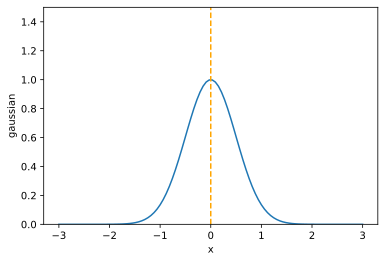

In [41]:
x_array = np.linspace(-3, 3, num=100)
plt.plot(x_array, gaussian(x_array))
plt.xlabel('x')
plt.ylabel('gaussian')
plt.ylim([0, 1.5])
plt.vlines(0, ymin=0, ymax=1.5, colors='orange', linestyles='dashed')
# plt.savefig('../pictures/3.3.svg')

In [42]:
def majority_vote(x, k_list, kd_tree, weight=False):
    dist_list = [k[0] for k in k_list]
    if weight:
        raw_weight_list = [gaussian(x, a=1/np.min(dist_list), b=np.min(dist_list), c=np.max(dist_list)) for x in dist_list]
        weight_list = [x / np.sum(raw_weight_list) for x in raw_weight_list]
    else:
        weight_list = np.ones_like(dist_list)
    
    y_dict = {} # 保留频率
    for i, (_, node) in enumerate(k_list):
        y = kd_tree.nodes[node]['point'][1]  # node的label
        y_dict[y] = y_dict.get(y, 0) + weight_list[i]
    
    return sorted(list(y_dict.items()), key=lambda x: x[1])[-1][0]

In [43]:
y = majority_vote(x, k_list, kd_tree, weight=True)
y

1

### 4.2. 回归

取`k`近邻对应y的平均值为输入实例的预测值
$$
\hat{y} = \frac{1}{k}\sum_{x_i\in N_k(x)}y_i
$$

In [44]:
def average_k_nn(x, k_list, kd_tree, weight=False):
    y_list = []
    dist_list = []
    for dist, node in k_list:
        y = kd_tree.nodes[node]['point'][1]
        y_list.append(y)
        dist_list.append(dist)
    
    if weight:
        weight_list = [gaussian(x) for x in dist_list]
        weight_list = [x / np.sum(weight_list) for x in weight_list]
    else:
        weight_list = np.ones_like(dist_list)
        
    pred_y = np.average(y_list, weights=weight_list)
    
    return pred_y

In [45]:
y = average_k_nn(x, k_list, kd_tree, weight=False)
y

0.6666666666666666

## 5. 应用


In [33]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import datasets

### 5.1.  基于身高和体重预测性别

|身高  |体重  |性别  |
|:---  |:--- |:--- |
|158cm |64kg | 男性 |
|170cm |66kg | 男性 |
|183cm |84kg | 男性 |
|191cm |80kg | 男性 |
|155cm |49kg | 女性 |
|163cm |59kg | 女性 |
|180cm |67kg | 女性 |
|158cm |54kg | 女性 |
|178cm |77kg | 女性 |

In [34]:
X_train = np.array([
    [158, 64],
    [170, 86],
    [183, 84],
    [191, 80],
    [155, 49],
    [163, 59],
    [180, 67],
    [158, 54],
    [178, 77]
])

y_train = np.array([1, 1, 1, 1, 0, 0, 0, 0, 0])  # 男性1, 女性0

In [36]:
x_test = np.array([
    [168, 65],
    [180, 96],
    [160, 52],
    [169, 67]
])

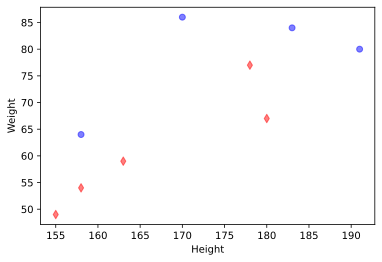

In [37]:
plt.figure()
plt.xlabel('Height')
plt.ylabel('Weight')

for i, x in enumerate(X_train):
    plt.scatter(x[0], x[1], c='b' if y_train[i] == 1 else 'r', marker='o' if y_train[i] == 1 else 'd', alpha=0.5)

In [46]:
tree = generate_kd_tree(X_train, y_train)
for i, x in enumerate(x_test):
    ini_node = search_kd_tree(x, 0, tree)
    k_list = find_k_neighbors(x, k=3, kd_tree=tree)
    y = majority_vote(x, k_list, kd_tree=tree)
    print(f'编号{i}, 特征{x}, 预测为{y} -- {"男性" if y==1 else "女性"}')

编号0, 特征[168  65], 预测为0 -- 女性
编号1, 特征[180  96], 预测为1 -- 男性
编号2, 特征[160  52], 预测为0 -- 女性
编号3, 特征[169  67], 预测为0 -- 女性


In [47]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)
clf.predict(x_test)

array([0, 1, 0, 0])

###  5.2. 鸢尾花类别预测

In [48]:
d = datasets.load_iris()

In [49]:
print(d["DESCR"])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [50]:
x_labels, y_labels = d['feature_names'], d['target_names']

In [51]:
rand_idx = np.arange(len(d['target']))
np.random.shuffle(rand_idx)

In [52]:
t_idx = rand_idx[:100]
v_idx = rand_idx[100:]

In [53]:
x_train, y_train = d['data'][t_idx], d['target'][t_idx]
x_test, y_test = d['data'][v_idx], d['target'][v_idx]

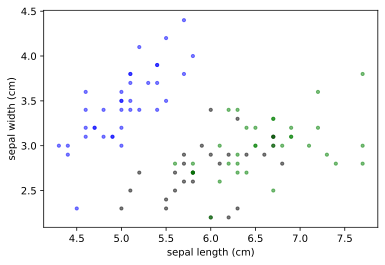

In [54]:
plt.figure()
plt.xlabel(x_labels[0])
plt.ylabel(x_labels[1])

x_0 = x_train[y_train == 0]
x_1 = x_train[y_train == 1]
x_2 = x_train[y_train == 2]

plt.scatter(x_0[:,0], x_0[:,1], s=10, c='b', marker='o', alpha=0.5)
plt.scatter(x_1[:,0], x_1[:,1], s=10, c='k', marker='o', alpha=0.5)
plt.scatter(x_2[:,0], x_2[:,1], s=10, c='g', marker='o', alpha=0.5)

In [55]:
tree = generate_kd_tree(x_train, y_train)

In [56]:
pred_y = []
for i, x in enumerate(x_test):
    k_list = find_k_neighbors(x, k=5, kd_tree=tree)
    y = majority_vote(x, k_list, kd_tree=tree, weight=False)
    pred_y.append(y)
#     print(f'编号{i}, 特征{x}, 预测为{y}, 实例为{y_valid[i]}')

pred_y = np.array(pred_y)
accuracy_score(pred_y, y_test)

0.94

In [57]:
clf2 = KNeighborsClassifier(n_neighbors=5)
clf2.fit(x_train, y_train)
pred_y_2 = clf2.predict(x_test)
accuracy_score(pred_y_2, y_test)

0.94

## 课后练习

构建`Ball tree`.

### `Ball tree`生成算法
- 输入: 特征X, 距离`dist_X`, 空树`tree`
- 输出: 结点为X的球树
- 算法过程
    - 初始化：计算任意点之间的距离并保存到矩阵中`dists`中，然后，选择到其它点最大距离最小的点作为球心，该点到其它点的最大距离作为半径构建初始超球体
    - 如果超球体中包含至少两个点，则执行以下递归；否则，返回
        - 找出距离当前球心最远的一个点`i`，并找到距离`i`最远的点`j`
        - 根据就近原则，将球体中的除球心外的点分别分配给`i`或`j`，形成两个点集合$set_i$和$set_j$
        - 分别针对$set_i$和$set_j$构建超球体，选择到其它点最大距离最小的点作为球心，该点到其它点的最大距离作为半径构建两个超球体，将各集合中的点包含在一个超球体中


In [44]:
def distance(xi, xj, p=2):
    return np.sum((np.abs(xi - xj))**p)**(1/p)

- 计算距离

In [45]:
def cal_distance(X, p=2):
    '''
    计算X中两两距离
    X: numpy.ndarray
    p: 范
    '''
    dist_dict = {}
    for i, x in enumerate(X):
        dist_dict[i] = np.sum((np.abs(x - X))**p, axis=1)**(1/p)
    return pd.DataFrame(dist_dict)

- 根据距离生成球树

In [46]:
def generate_ball_tree(X, dist_X, tree=nx.DiGraph()):
    '''
    dist_X: 样本点之间的距离矩阵, pandas.DataFrame
    tree: 用来保持结构的树
    划分思想: 每个样本点有且仅作为一次超球体的球心(注意, 叶节点对应一个点，即半径为0)
    球心的确定: 样本中到其它点的最大距离最小的点作为球心, 其对应的最大距离作为半径
    '''
    node_id = 0
    tree.add_node(node_id)
    tree.nodes[node_id]["indices"] = list(dist_X.index)  # 球体内数据对应的索引列表
    undivide_nodes = [node_id]
    while undivide_nodes:
        new_nodes = []
        for node in undivide_nodes:
            indices = tree.nodes[node]["indices"]
            d_X = dist_X[indices].loc[indices]  # 球体内点之间的距离
            idx_center = d_X.max().idxmin()  # 球心对应的索引
            tree.nodes[node]["center"] = X[idx_center]
            if len(d_X) == 1:  # 叶结点: 只有1个样本
                tree.nodes[node]["type"] = "leaf"
                tree.nodes[node]["radius"] = 0  # 叶结点的半径为0
            else:  # 非叶结点
                tree.nodes[node]["type"] = "internal" if node !=0 else "root"
                tree.nodes[node]["radius"] = d_X[idx_center].max()  # 最大距离作为球体半径
                # 寻找两个子球心，并根据距离划分两个样本子集
                x0 = d_X[idx_center].idxmax()  # 距离球心idx_center最远的点作为第1个子球心
                x1 = d_X[x0].idxmax()  # 距离子球心x0最远的点
                # 对应球体中点的索引（应去掉球心）
                indices0 = list(set(d_X[x0][d_X[x0] <= d_X[x1]].index) - set([idx_center]))  # 距离x0比x1更近的点对应的所有索引
                indices1 = list(set(d_X[x1][d_X[x0] > d_X[x1]].index) - set([idx_center]))  # 距离x1比x2更近的点对应的所有索引
                # 子样本1: 去掉球心，如果还有数据，增加1个新节点
                if len(indices0) > 0:
                    new_node = node_id + 1
                    tree.add_edge(node, new_node)
                    tree.nodes[new_node]["indices"] = indices0
                    new_nodes.append(new_node)
                    node_id += 1
                # 子样本2: 去掉球心，如果还有数据，增加1个新节点
                if len(indices1) > 0:
                    new_node = node_id + 1
                    tree.add_edge(node, new_node)
                    tree.nodes[new_node]["indices"] = indices1
                    new_nodes.append(new_node)
                    node_id += 1
                
        undivide_nodes = new_nodes
        
    return tree

示例

In [47]:
X = np.random.randint(low=0, high=100, size=(11, 6))
y = np.ones(X.shape[0], dtype=np.int32)
y[np.random.rand(y.size) < 0.5] = 0

dist_X = cal_distance(X, p=2)  # 点之间的距离
ball_tree = generate_ball_tree(X, dist_X, tree=nx.DiGraph())

ball_tree.number_of_nodes()

11

In [48]:
dist_X[1][dist_X[1] < dist_X[3]].index  # 距离点1比点3更近的点对应的所有索引

Int64Index([1, 8], dtype='int64')

In [49]:
dist_X.max().idxmin()

0

In [50]:
dist_X.idxmax()

0     1
1     4
2     9
3     9
4     1
5     4
6     8
7     5
8     6
9     1
10    1
dtype: int64

In [51]:
for i in ball_tree:
    print(i, ball_tree.nodes[i]['center'])

0 [47 49 50 12 83 58]
1 [48 89 99 63 39 69]
2 [82 21  0 20 71 79]
3 [10 87 86  1 75 86]
4 [27 40 97 63  8 52]
5 [43 88 38  9 57 99]
6 [99 74  2 58 77 46]
7 [92 97 93  5 41 97]
8 [87 45 94 53 57 62]
9 [27 55 58 87 55 39]
10 [28 80 51 49 25 33]


In [ ]:
ball_tree.edges()

OutEdgeView([(0, 1), (0, 2), (1, 3), (1, 4), (2, 5), (2, 6), (3, 7), (4, 8), (4, 9), (9, 10)])

### `Ball-tree`搜索算法

- 输入: 训练完毕的球树`tree`, 目标点`x`, 邻居数量`k`
- 输出: 邻居列表`k_list`
- 算法过程:
     - 在`Ball`树中找到包含目标点`x`的**某一**叶结点：
        - 从根节点出发，递归地向下访问`Ball`树：分别计算x与当前球体下两个子球体球心的距离，往距离小的子结点移动，直至某一叶结点；
        - 令叶结点为当前结点`node`；
     - 如果`node is None`，则跳转至(3); 否则，进行以下循环：
        - 如果`node`已被访问过，则下一轮的结点为`node`的父结点`parent_node`，即`node:=parent_node`
        - 否则
            - 将`node`标记为已访问
            - 判断是否将`node`添加至`k_list`：
                - 计算`node`至`x`的距离`dist_node_x`，如果 **`k_list`的元素个数小于`k`**或者**`dist_node_x`小于`k_list`中的最远距离** ，将`(dist_node_x, node)`添加至`k_list`，且保留距离`x`最近的`k`个距离及其结点;
            - 更新下一轮需访问的结点
                - 如果`node`为叶结点，则下一轮的结点为`node`的父结点`parent_node`，即`node:=parent_node`
                - 如果`node`为非叶结点，计算`x`至`node`球心距离`dist_node_x`
                    - 如果`dist_node_x`大于等于`k_list`中的最大距离和以`node`为球心的球体半径之和
                        - 若`node`有父结点，则`node:=parent_node`
                        - 若`node`无父结点(即为跟节点)，则`node:=None`
                    - 如果 **`k_list`的元素个数小于`k`** 或者 **`dist_node_x`小于`k_list`中的最大距离和以`node`为球心的球体半径之和**，则搜索以`node`未被访问的另一分支，找到该分支距离`x`最近的叶结点，并将其设为`node`
     - 输出最近邻列表`k_list`

- 说明:
> "`dist_node_x`大于等于`k_list`中的最大距离和以`node`为球心的球体半径之和"即利用三角不等式判断

In [146]:
def search_ball_tree(x, node, ball_tree):
    '''
    搜索node在哪个区域(叶结点)
    '''
    if ball_tree.nodes[node]['type'] != 'leaf':
        children = list(ball_tree.successors(node))
        if len(children) == 2:  # 有两个子结点
            c1, c2 = children
            center1 = ball_tree.nodes[c1]['center']
            center2 = ball_tree.nodes[c2]['center']
            dist_c1 = distance(x, center1)
            dist_c2 = distance(x, center2)
            if dist_c1 <= dist_c2:  # 比较x到两个子球体球心的距离
                return search_ball_tree(x, c1, ball_tree)
            else:
                return search_ball_tree(x, c2, ball_tree)
        else:  # 只有1个子结点
            c1 = children[0]
            return search_ball_tree(x, c1, ball_tree)
    else:
        return node

In [147]:
def find_k_neighbors_ball_tree(x, node, k, ball_tree):
    '''
    从叶结点node回退
    k_list保存离x最近的k个点
    '''
    k_list, trace_list = [], []
    while node is not None:
        if node not in trace_list:
            trace_list.append(node)
            dist_node_x = distance(x, ball_tree.nodes[node]['center'])
            # 更新k_list: 不足k个或者到node的距离小于等于k_list中最大距离
            if len(k_list) < k or dist_node_x <= k_list[-1][0]:
                k_list.append([dist_node_x, node])
                k_list = sorted(k_list)[:k]
            # 获取下一个需要遍历的点
            # 1. 叶结点
            if ball_tree.nodes[node]['type'] == 'leaf':  # 往上
                parent_nodes = list(ball_tree.predecessors(node))  # 获取node的直接父结点
                node = parent_nodes[0] if parent_nodes else None
            else: # 2. 非叶结点
                parent_nodes = list(ball_tree.predecessors(node))  # 获取node的直接父结点
                if dist_node_x > k_list[-1][0] + ball_tree.nodes[node]['radius']:  # 往上
                    node = parent_nodes[0] if parent_nodes else None
                else:  # 往下
                    c_node = [i for i in ball_tree.successors(node) if i not in trace_list]
                    if len(c_node) == 1:  # 若有2个子结点，往下搜索
                        node = search_ball_tree(x, c_node[0], ball_tree)
                    else:  # 若只有1个子结点，往父结点走
                        node = parent_nodes[0] if parent_nodes else None
                        
        else:  # 若被遍历过，则查看其父结点
            c_nodes = list(ball_tree.predecessors(node))
            node = c_nodes[0] if c_nodes else None
            
    return k_list

- 示例

In [148]:
X = np.random.randint(low=0, high=100, size=(100, 6))
y = np.ones(X.shape[0], dtype=np.int32)
y[np.random.rand(y.size) < 0.5] = 0

dist_X = cal_distance(X, p=2)  # 点之间的距离

ball_tree = generate_ball_tree(X, dist_X, tree=nx.DiGraph())

In [149]:
x = np.random.randint(low=0, high=100, size=(6,))

In [150]:
node = search_ball_tree(x, 0, ball_tree=ball_tree)
k_list = find_k_neighbors_ball_tree(x, node, k=3, ball_tree=ball_tree)

k_list

[[39.20459156782532, 43], [45.86937976471886, 71], [52.478567053607705, 26]]

In [151]:
dist_X_x = np.array([distance(x, i) for i in X])
sorted(dist_X_x)

[39.20459156782532,
 45.86937976471886,
 52.478567053607705,
 57.697486947006624,
 63.047601064592456,
 65.13063795173512,
 65.25335240430181,
 65.55913361233506,
 66.90291473471092,
 69.05794668247819,
 69.34695379034324,
 75.15317691222374,
 77.89736837660179,
 80.0812087820857,
 80.64118054691411,
 81.17881497040962,
 82.87943049997388,
 83.33666660000267,
 84.10707461325711,
 84.27336471270148,
 84.44524853418338,
 84.75848040166836,
 85.31119504496465,
 86.79861750051091,
 87.36131867136622,
 87.46999485537883,
 87.86922100485471,
 88.79752248796134,
 89.14594774862175,
 89.2972563968233,
 90.5869747811461,
 90.6311204829776,
 91.90212184710427,
 93.5200513259055,
 94.82088377567464,
 95.01578816175763,
 95.36246641105713,
 96.0572745813663,
 96.18731725128839,
 96.38464608017192,
 96.6798841538404,
 98.76234100101111,
 99.2169340384997,
 99.61927524329818,
 100.66777041337511,
 100.69260151570224,
 100.69756700139284,
 100.71246198956712,
 101.24228365658294,
 101.42484902626181,